In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Aug 18 21:41:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    62W / 300W |  10009MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [3]:
n_mels = 80
n_outputs = 61
n_frames = 400

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256, dilation_rate=2)
model = model.to(device)
print('done')

done


In [13]:
!ls -lt /data/scpark/save/lips/train08.17-2/

total 6435560
-rw-rw-r-- 1 scpark scpark      9504  8월 19 03:54 events.out.tfevents.1692258273.GPUSVR11
-rw-rw-r-- 1 scpark scpark 658995783  8월 19 01:47 save_90000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 21:41 save_80000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 18:34 save_70000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 15:37 save_60000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 12:27 save_50000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 08:27 save_40000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 04:27 save_30000
-rw-rw-r-- 1 scpark scpark 658995783  8월 18 00:24 save_20000
-rw-rw-r-- 1 scpark scpark 658995783  8월 17 20:33 save_10000
-rw-rw-r-- 1 scpark scpark 658982127  8월 17 16:46 save_0
-rw-rw-r-- 1 scpark scpark         0  8월 17 16:43 events.out.tfevents.1692258234.GPUSVR11


In [14]:
path = '/data/scpark/save/lips/train08.17-2/save_90000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [7]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 guhyun guhyun 1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark scpark 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark scpark 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 guhyun guhyun 1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 guhyun guhyun 1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 guhyun guhyun  983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 guhyun guhyun  971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 guhyun guhyun  954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 guhyun guhyun  928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 guhyun guhyun  917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 guhyun guhyun  917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 guhyun guhyun  913841  5월 11 19:48 1098.spec.pt
-rwxrwxrwx 1 scpark scpark

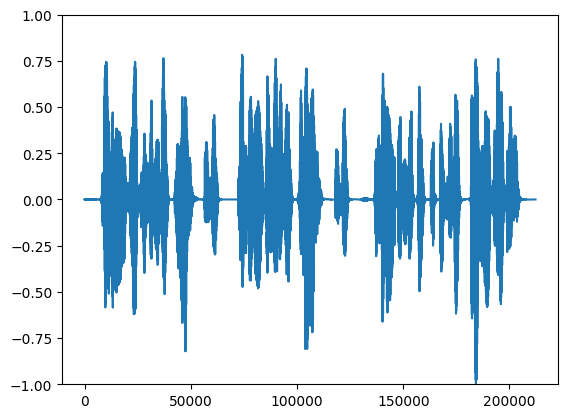

In [19]:
import matplotlib.pyplot as plt
wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [20]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    
def get_blendshape(wav, sid):
    mel = get_mel(torch.Tensor(wav).unsqueeze(0)).to(device)
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(mel, sid=sid, temperature=0.2)
    y = y[0].data.cpu().numpy()
    return mel[0].data.cpu().numpy(), y
    

In [ ]:
ys = []
for sid in range(1, 8):
    mel, y = get_blendshape(wav, sid)
    ys.append(y)
    
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=[18, 4])
librosa.display.specshow(y, cmap='magma')
plt.colorbar()
plt.show()

for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    librosa.display.specshow(mel, cmap='magma')
    for sid in range(len(ys)):
        plt.plot(ys[sid][i] * 80, color='white')
    plt.show()


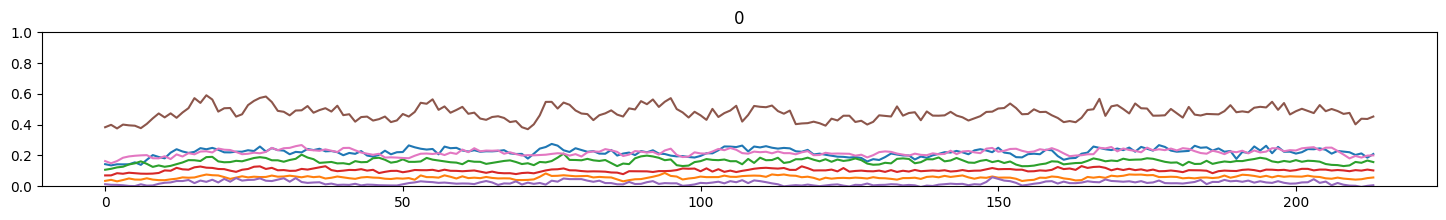

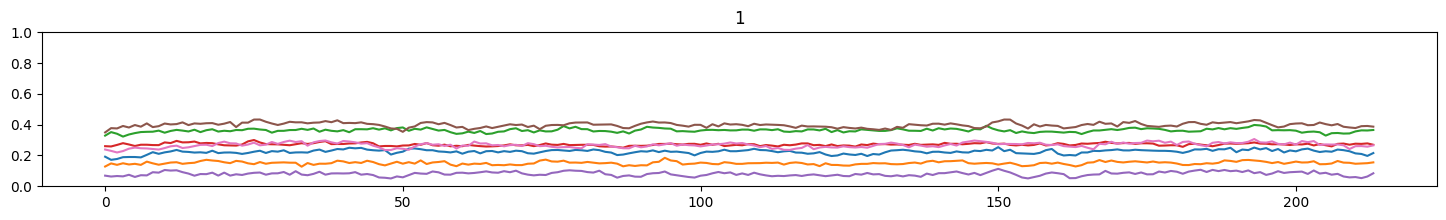

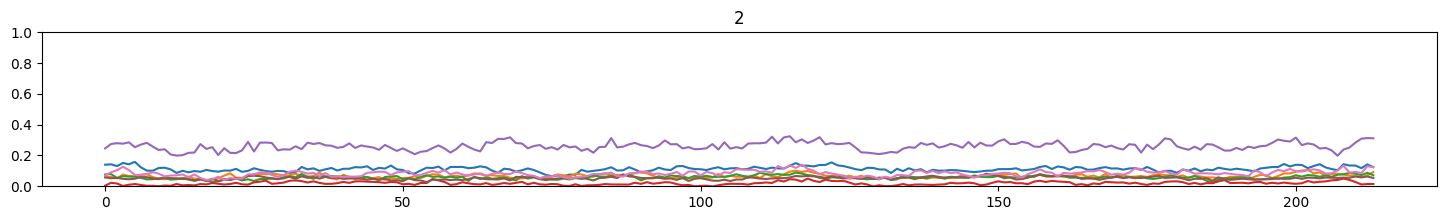

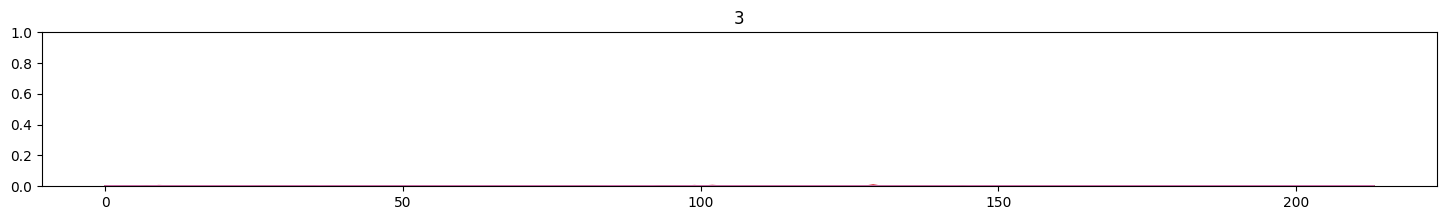

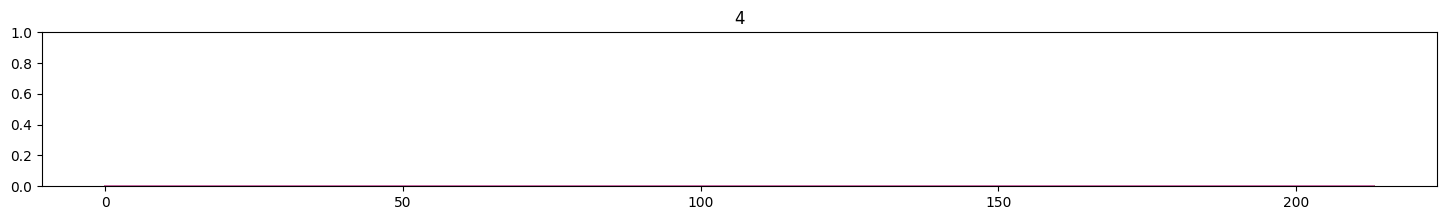

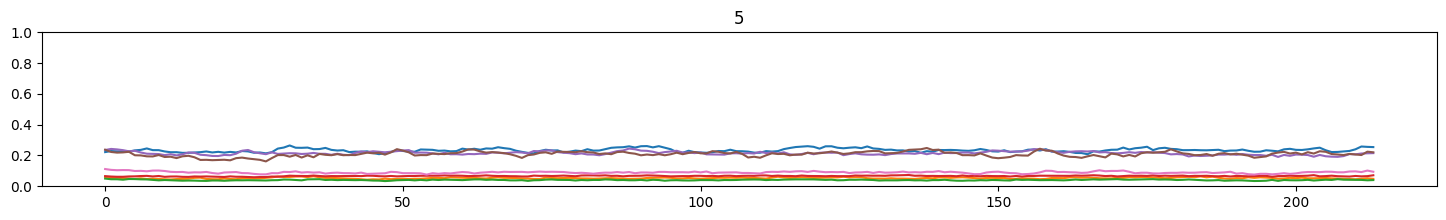

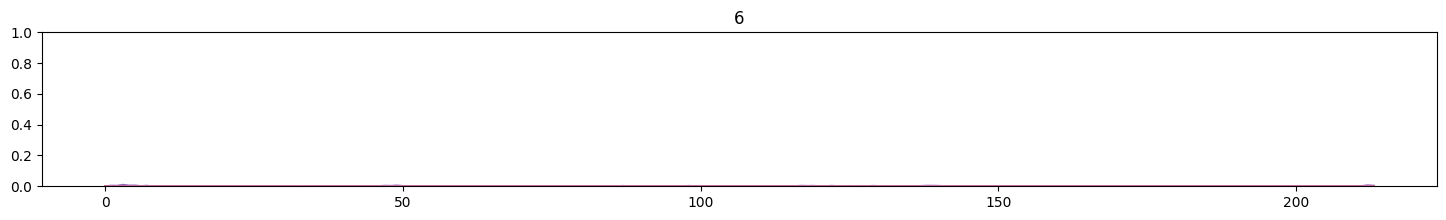

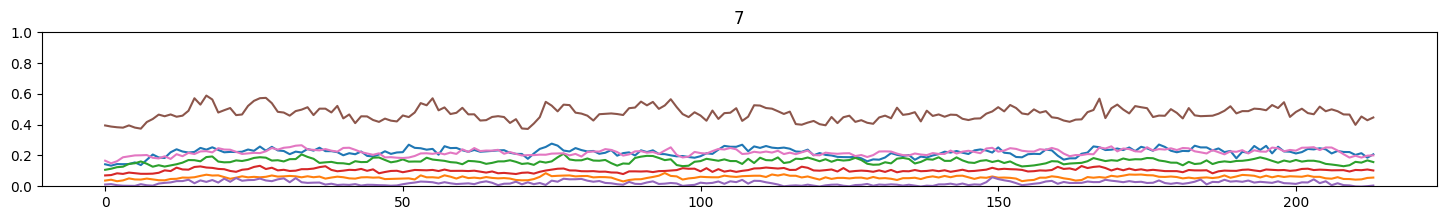

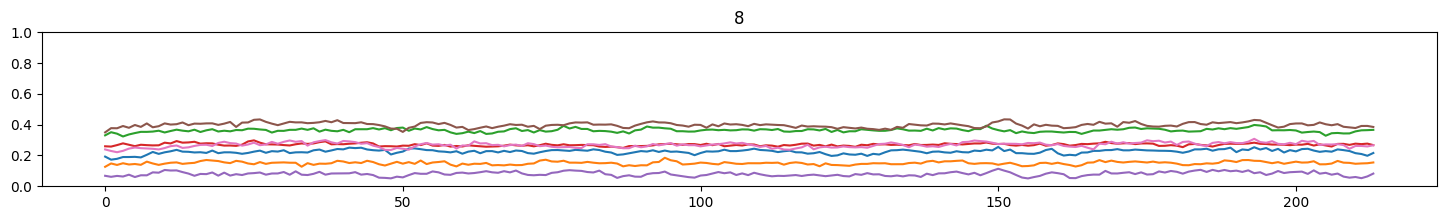

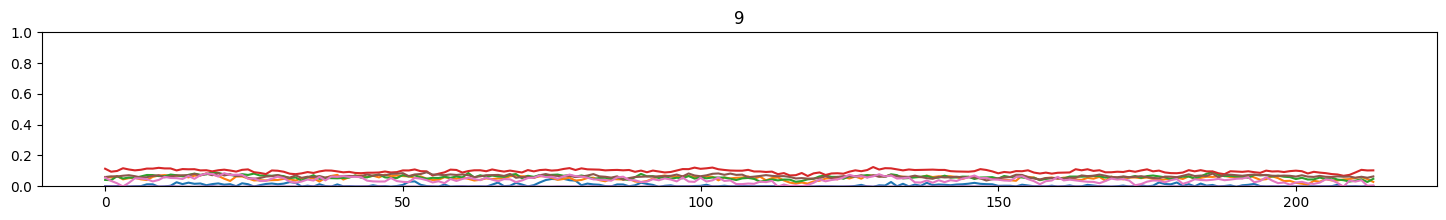

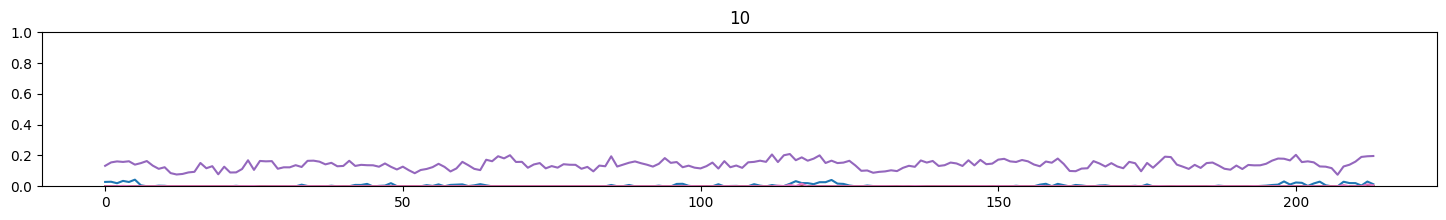

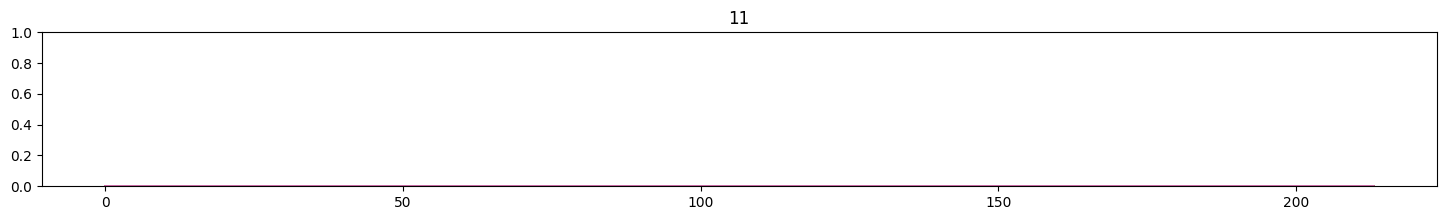

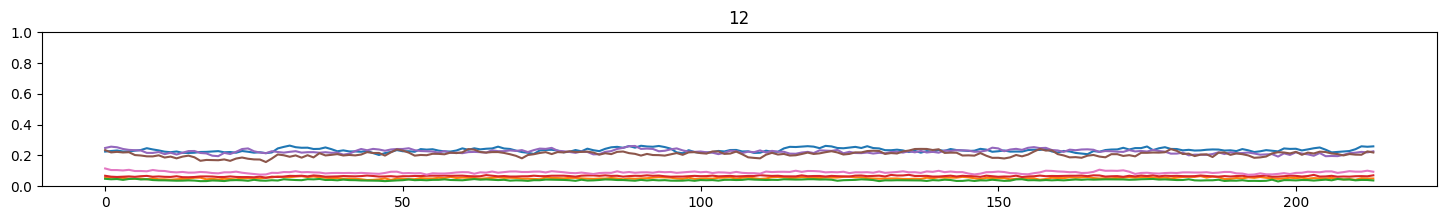

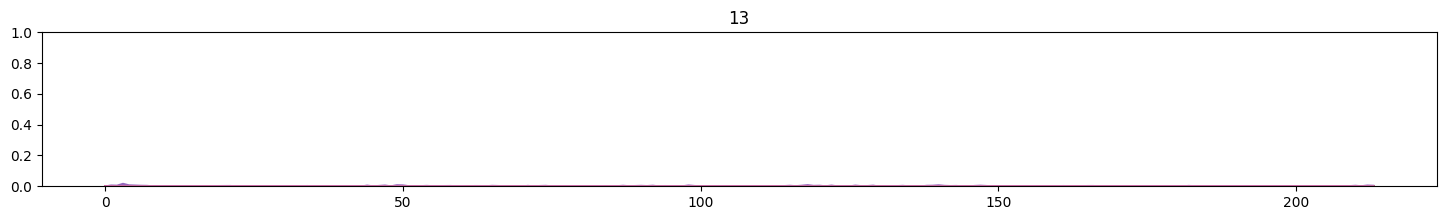

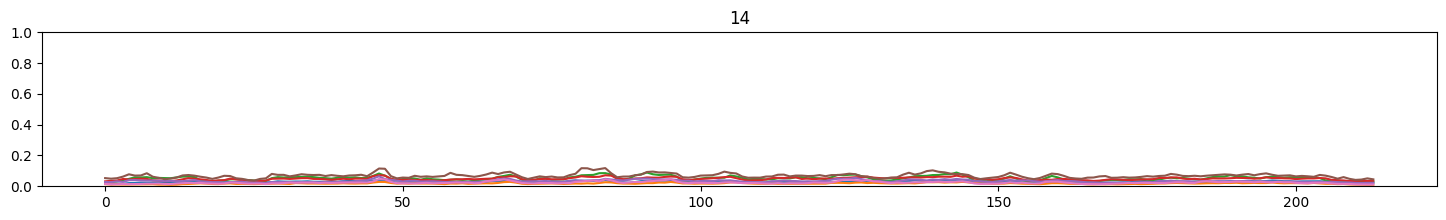

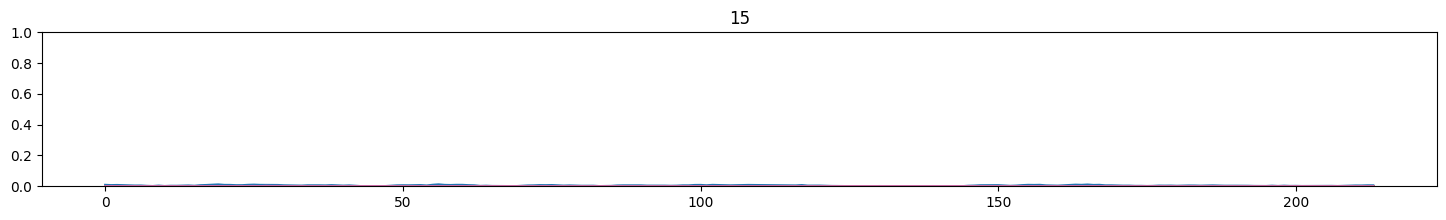

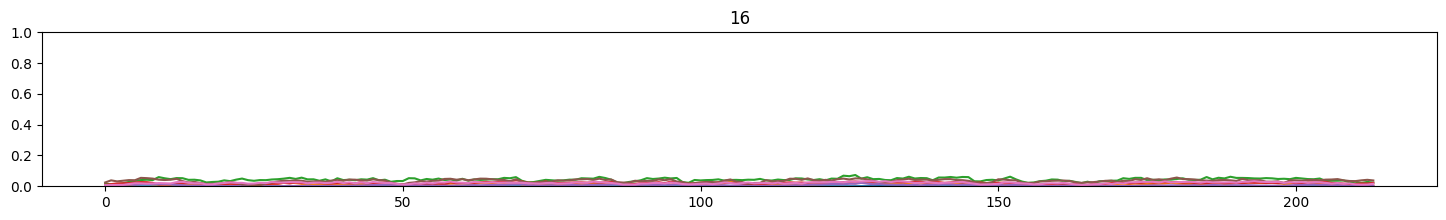

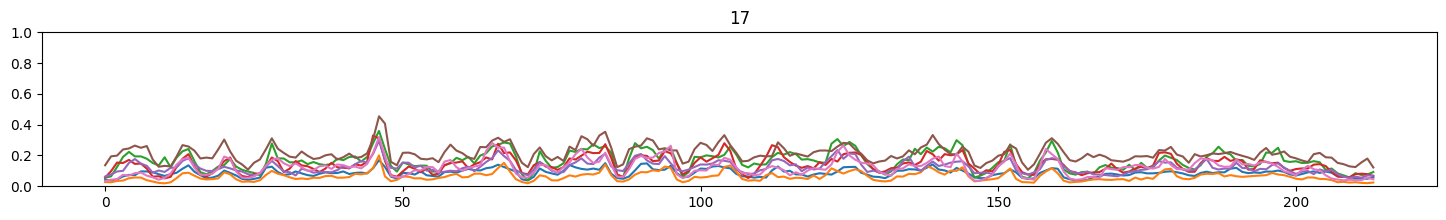

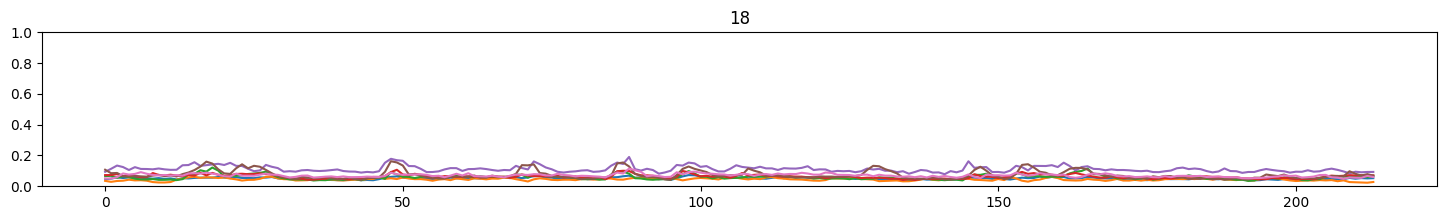

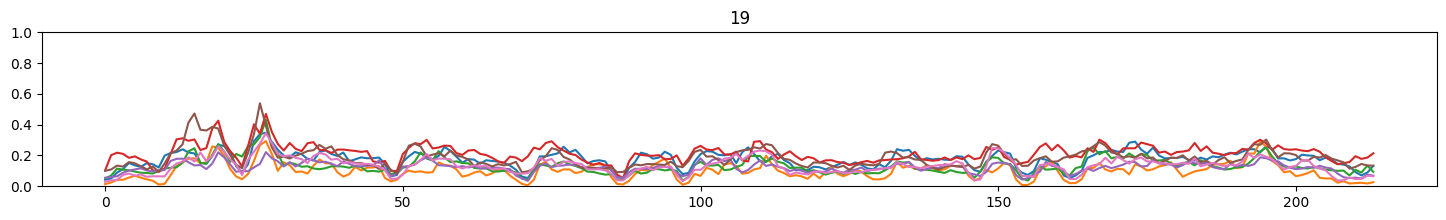

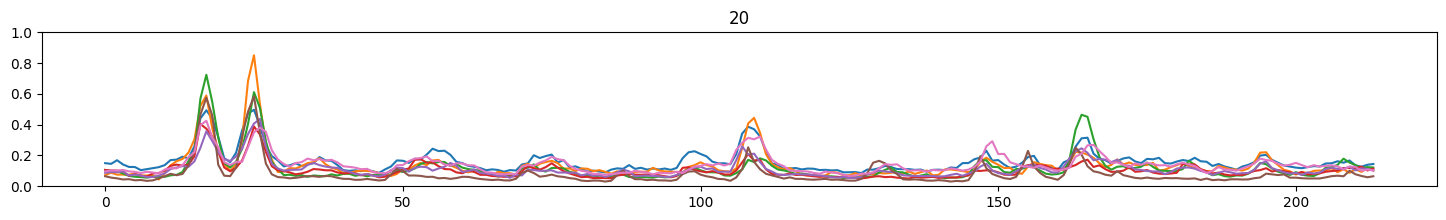

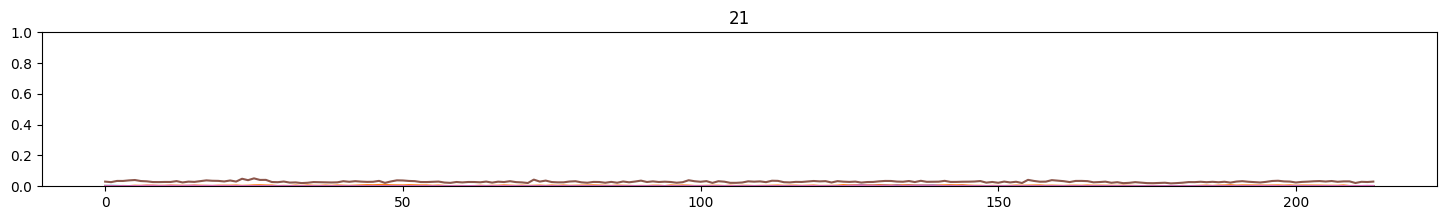

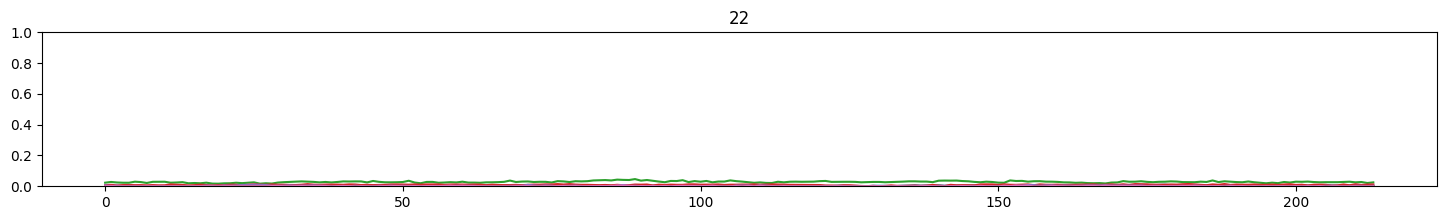

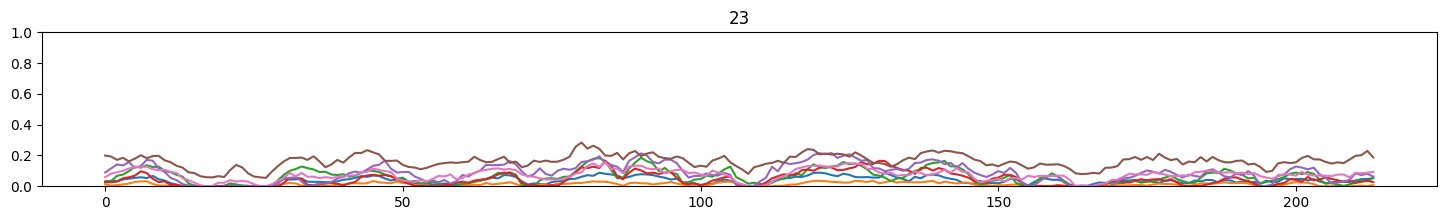

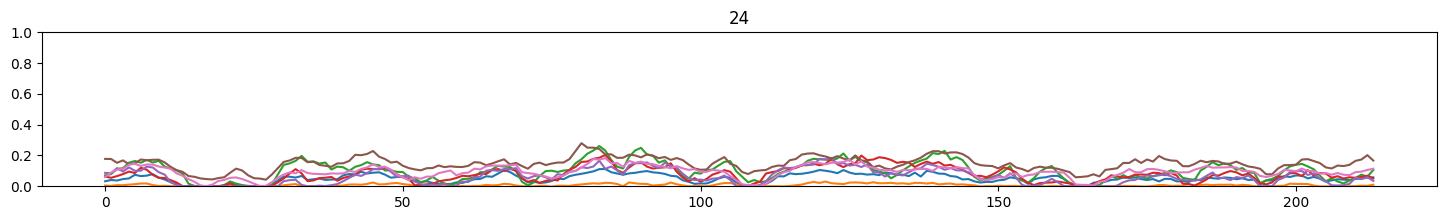

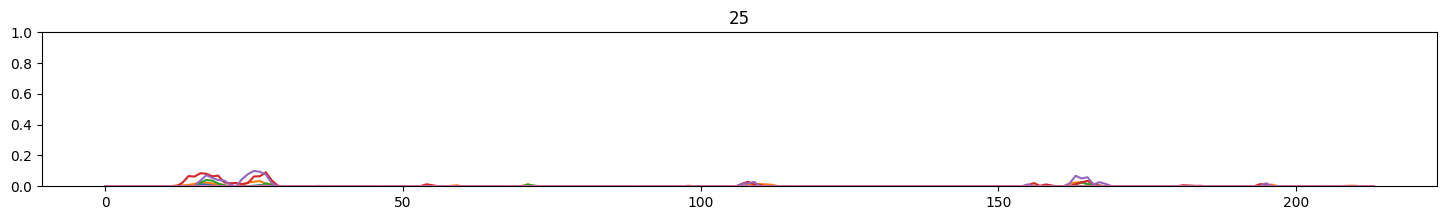

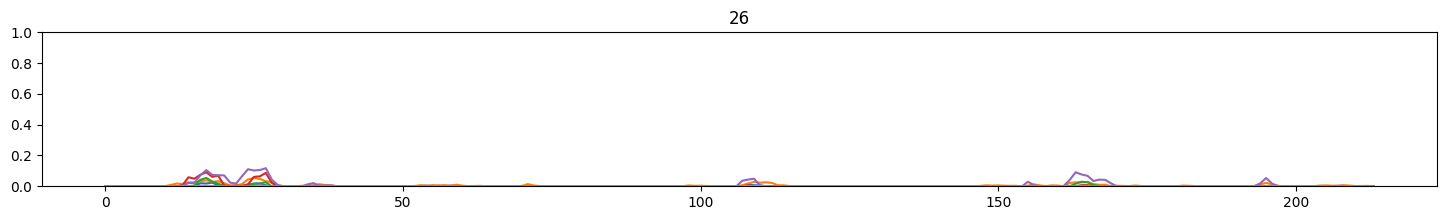

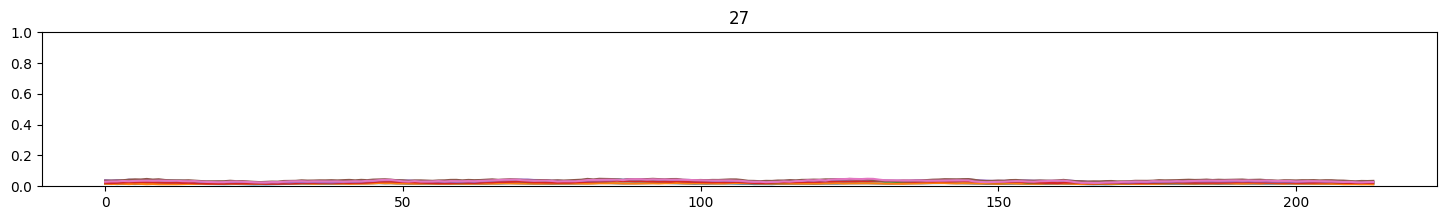

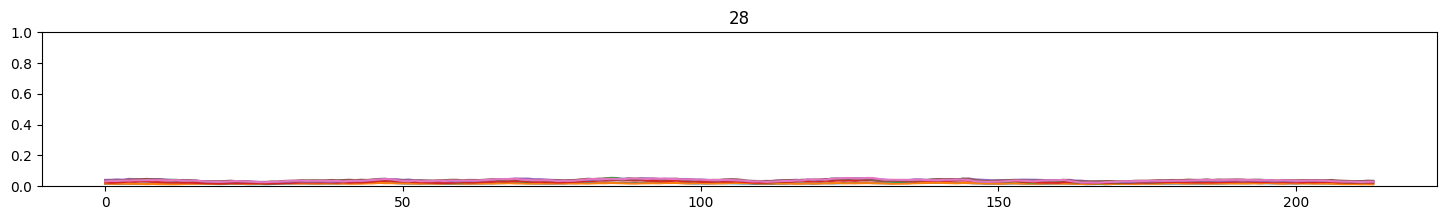

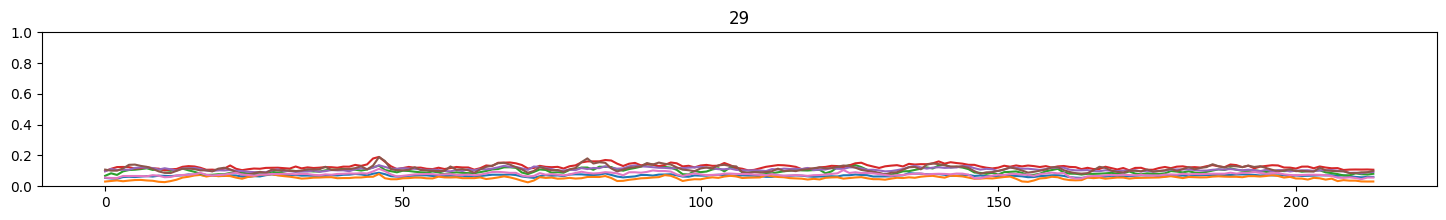

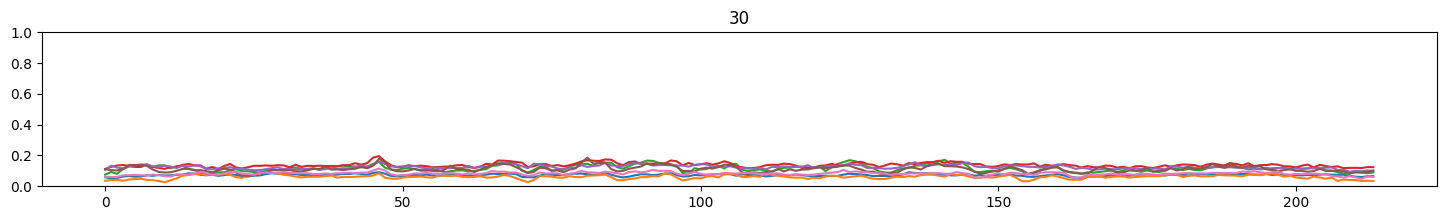

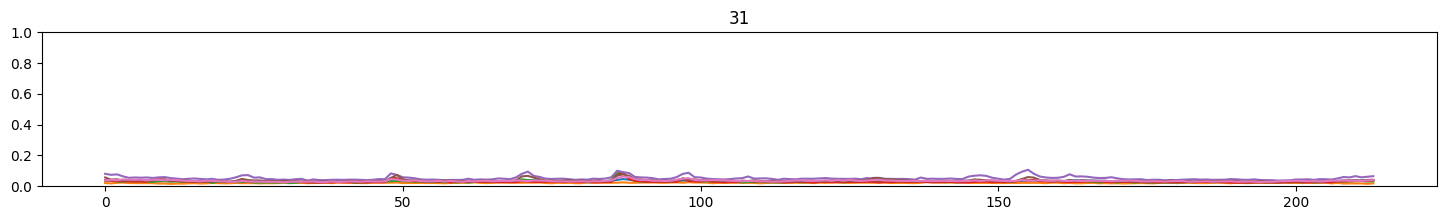

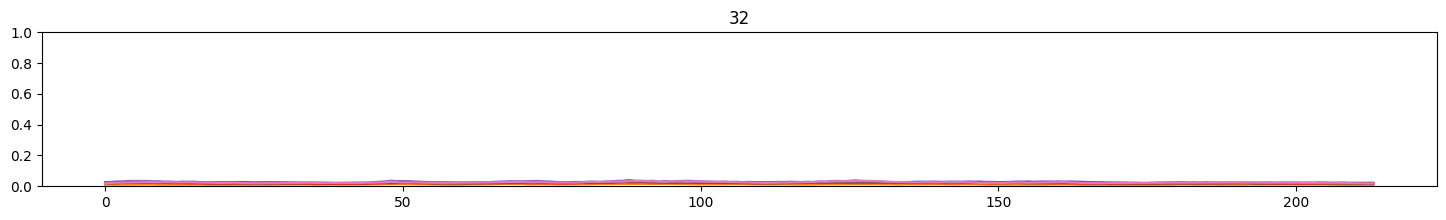

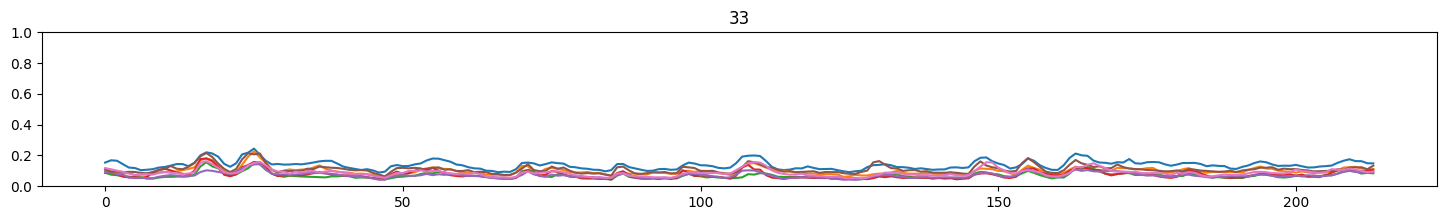

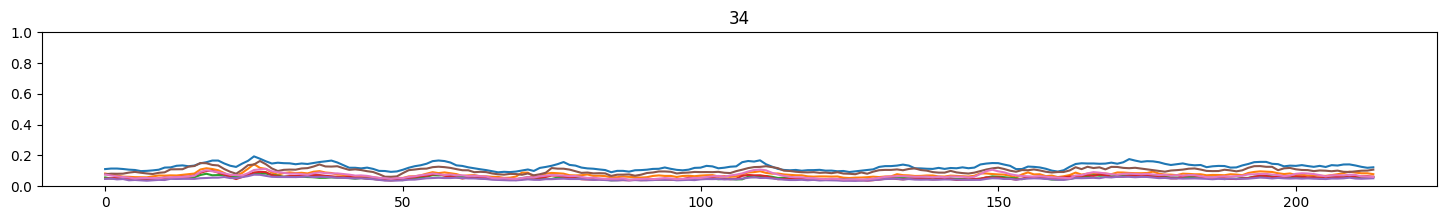

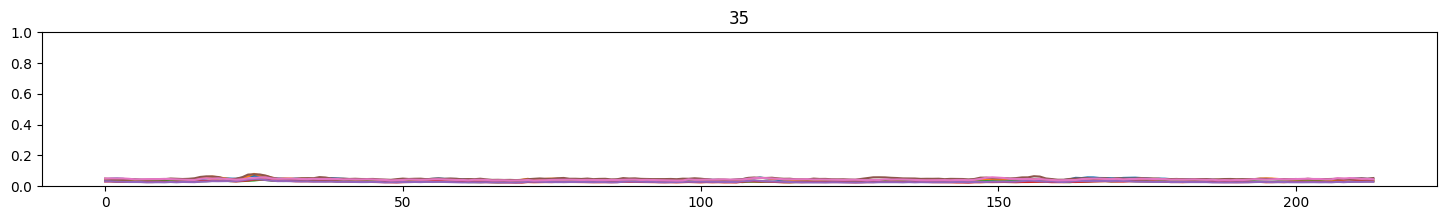

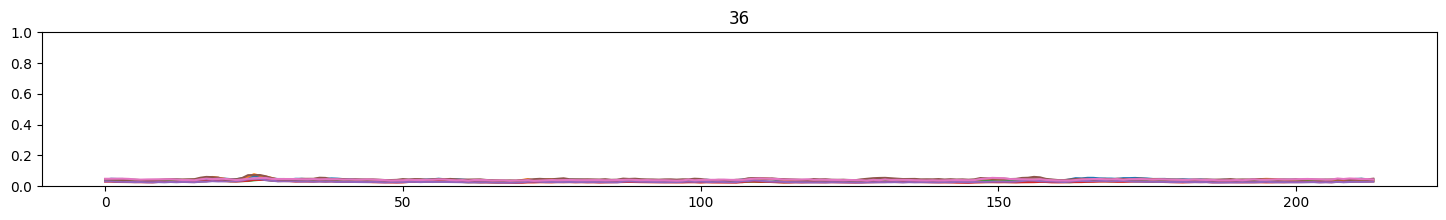

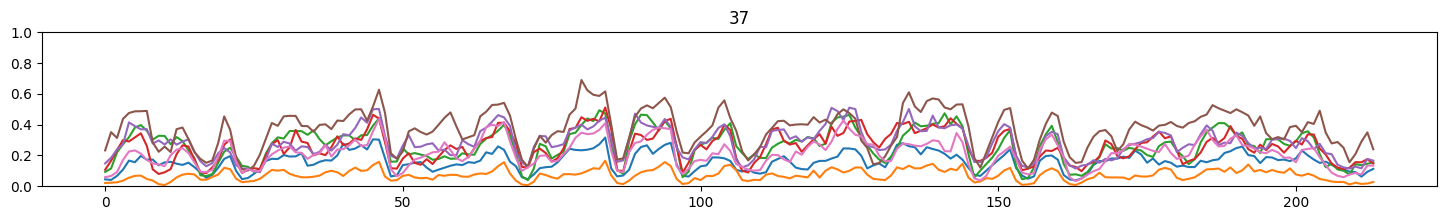

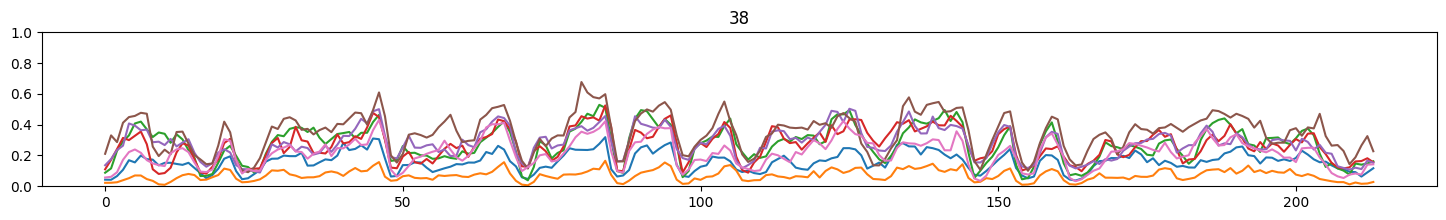

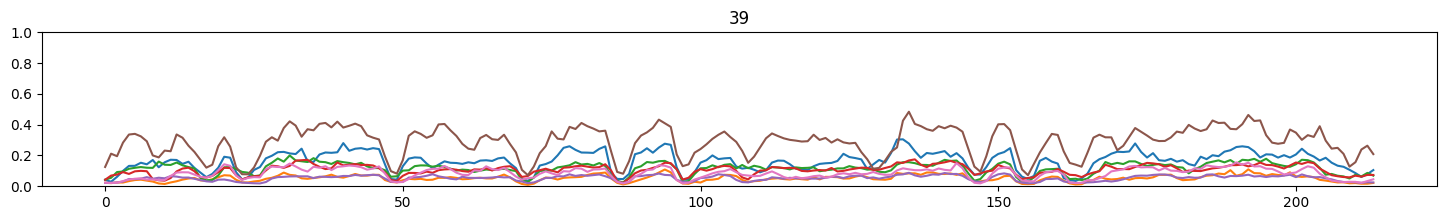

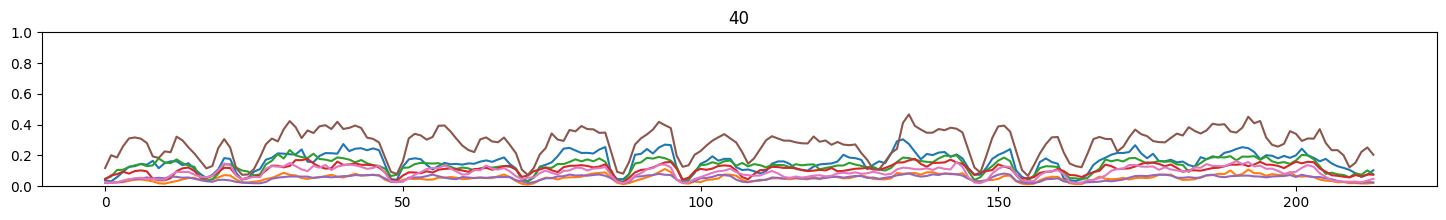

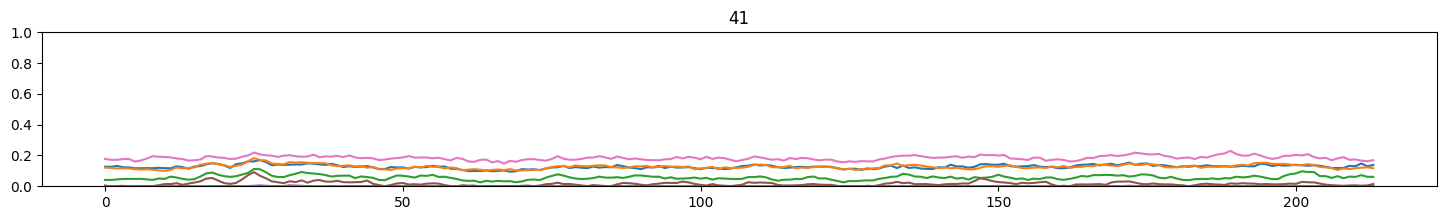

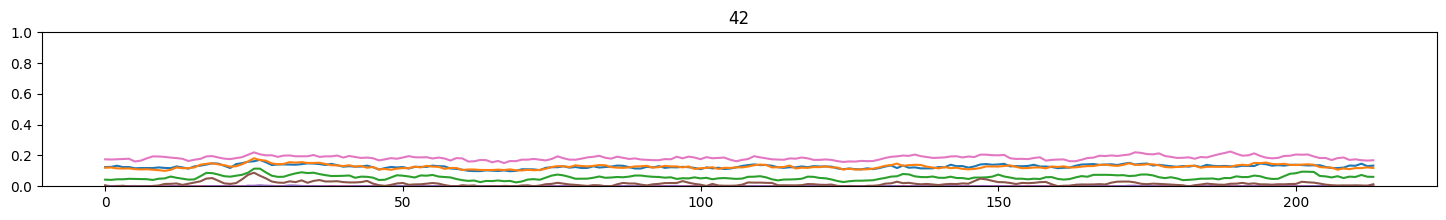

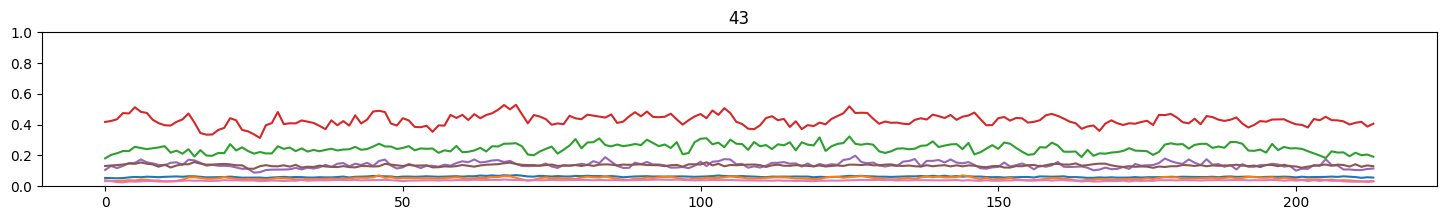

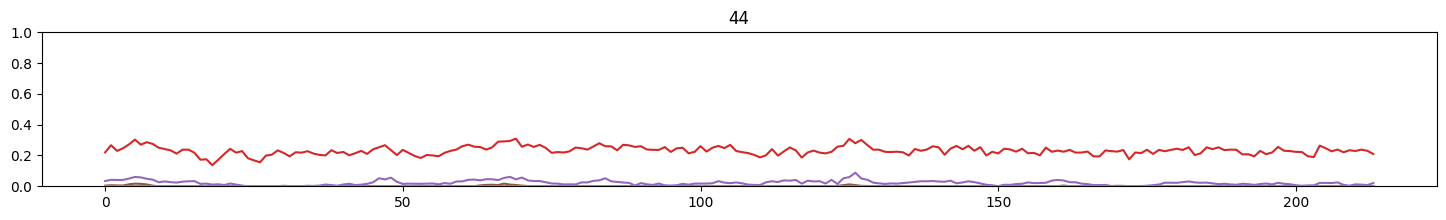

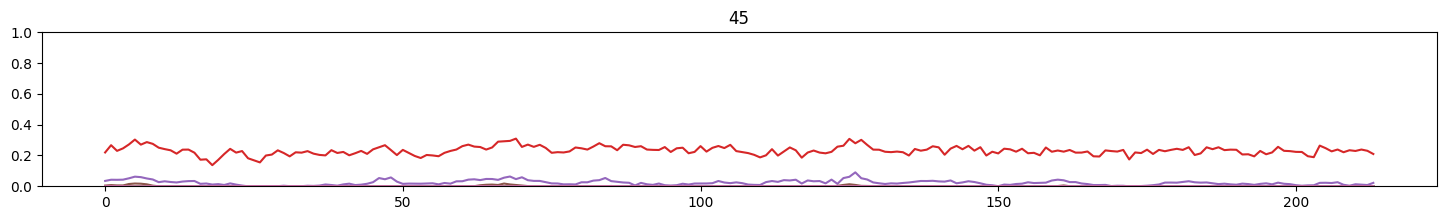

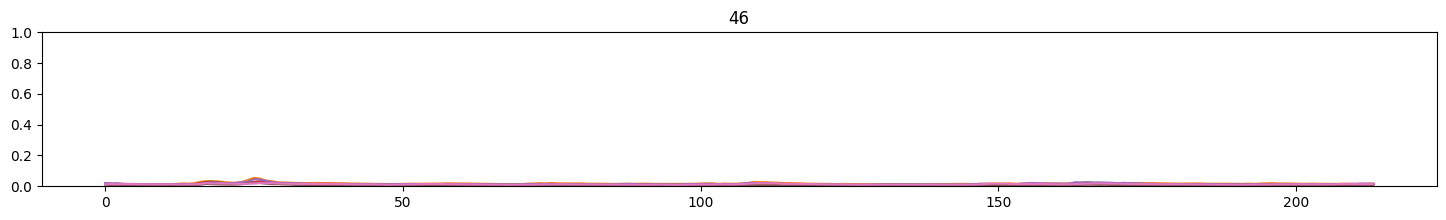

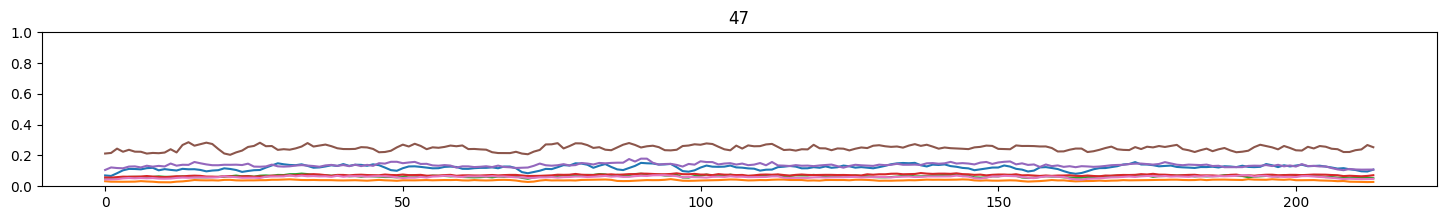

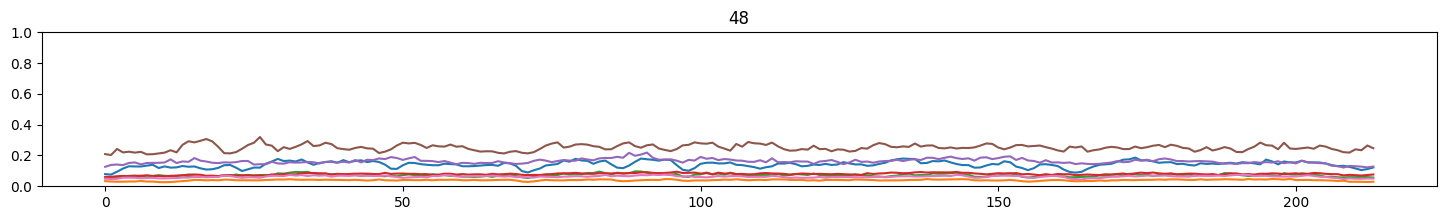

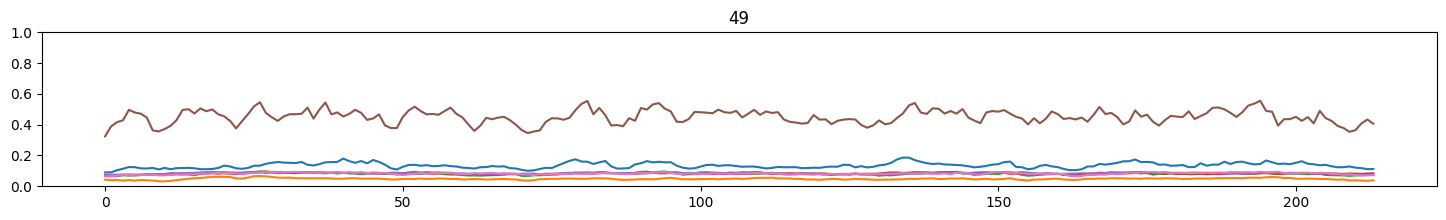

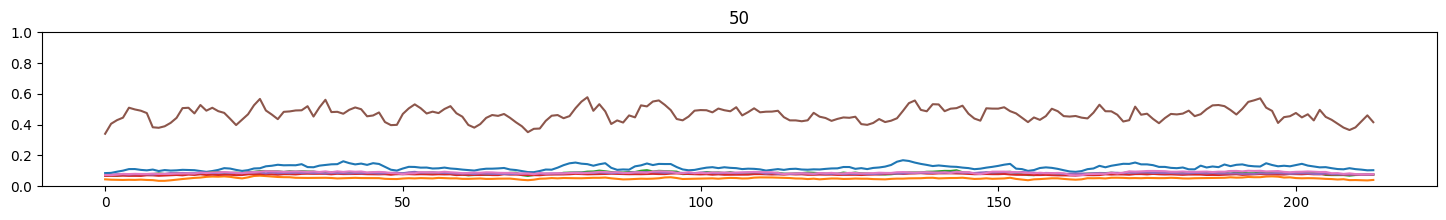

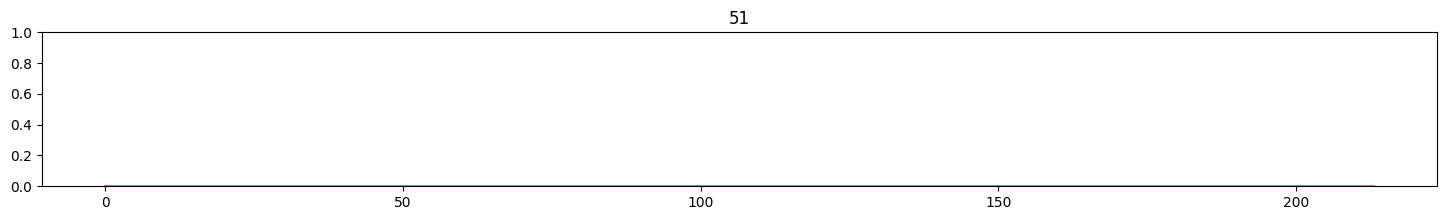

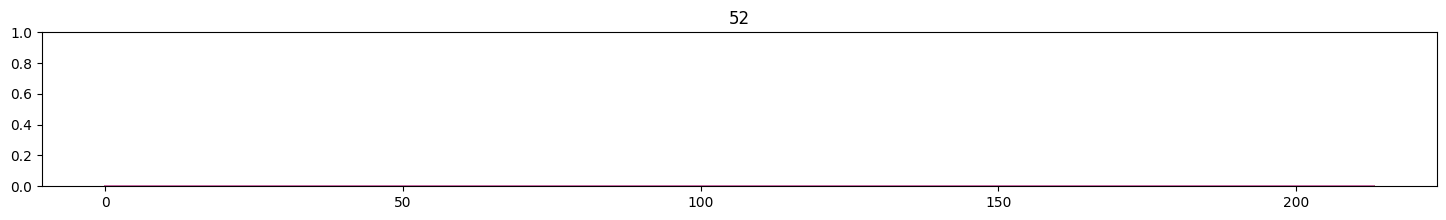

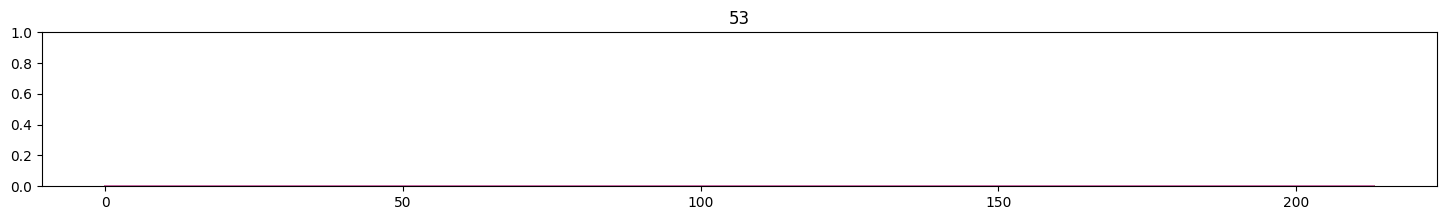

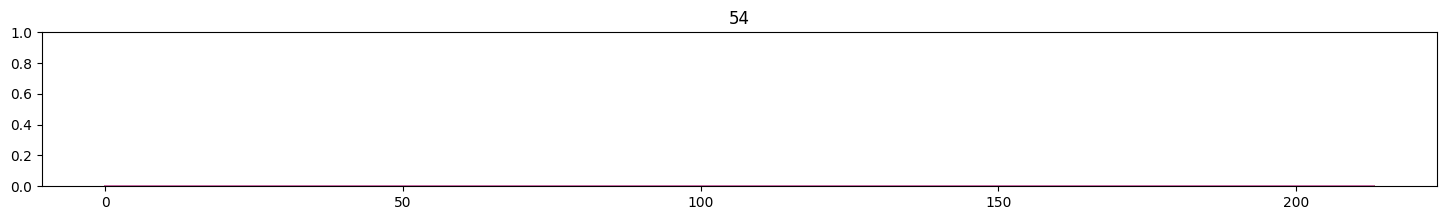

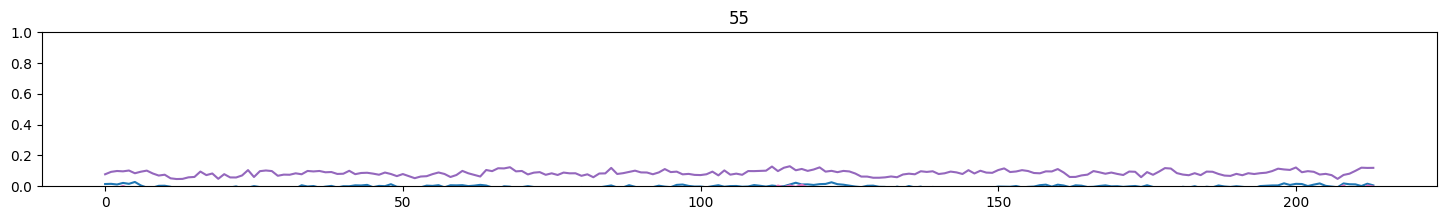

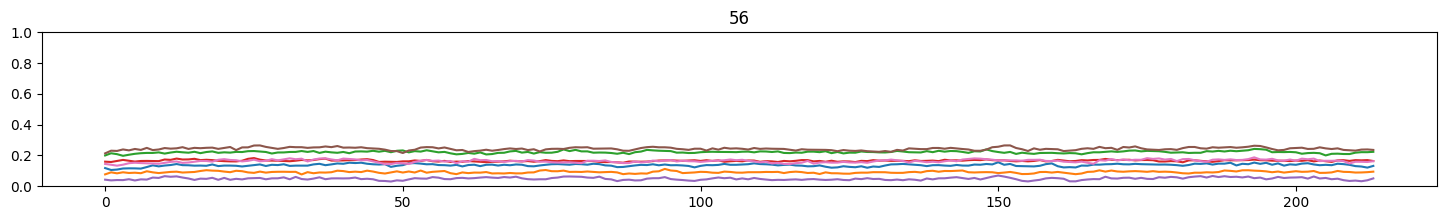

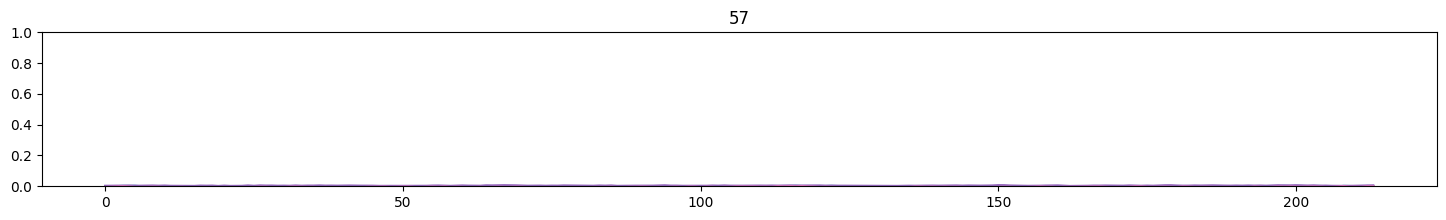

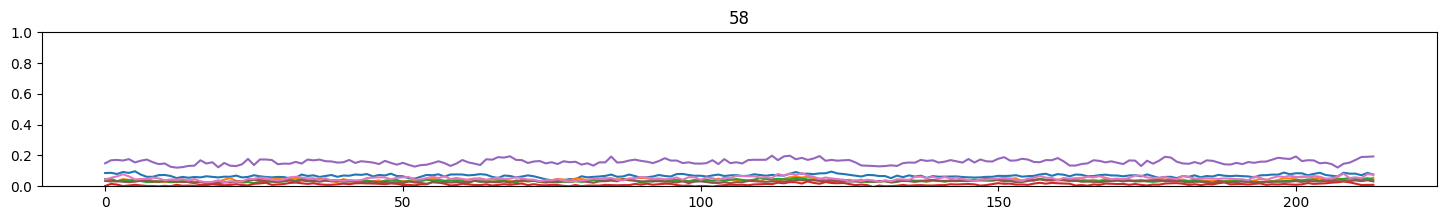

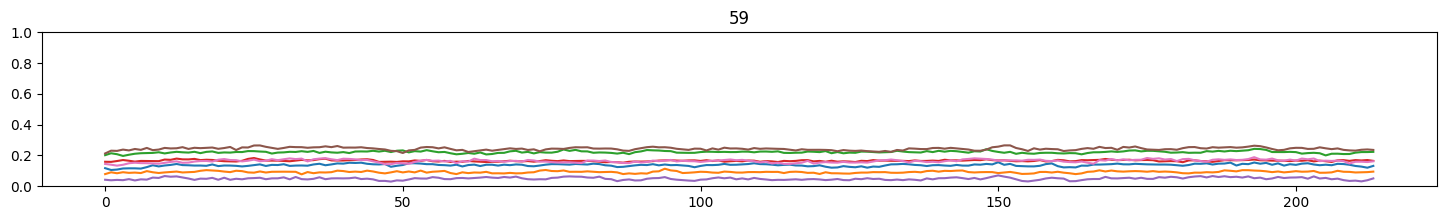

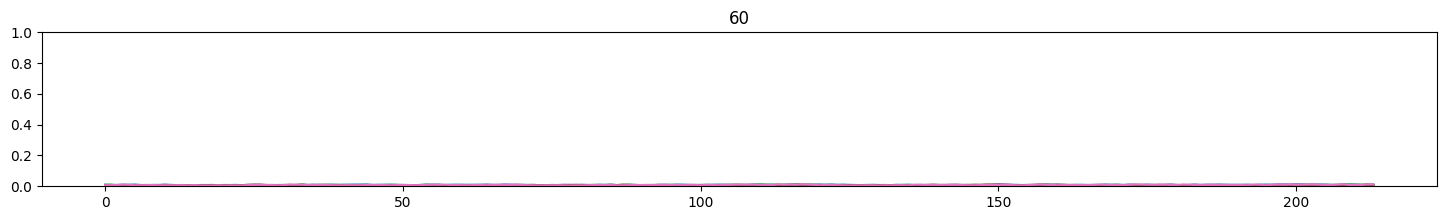

In [18]:
for i in range(0, 61):
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    for sid in range(len(ys)):
        plt.plot(ys[sid][i])
        plt.ylim([0, 1])
    plt.show()
